In [8]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold,GroupKFold,GridSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

import gc
import pickle
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [12]:
root_path = "../../../input/"
train = np.load("../../data_preprocessing/new_cite_train_final.npz")["arr_0"]
target = pd.read_hdf(f"{root_path}open-problems-multimodal/train_cite_targets.h5").values
target -= target.mean(axis=1).reshape(-1, 1)
target /= target.std(axis=1).reshape(-1, 1)
print(train.shape,target.shape)

(70988, 735) (70988, 140)


In [13]:
train_index = np.load("../data/sparse_cite/train_cite_inputs_idxcol.npz",allow_pickle=True)
meta = pd.read_csv("../data/metadata.csv",index_col = "cell_id")
meta = meta[meta.technology=="citeseq"]
lbe = LabelEncoder()
meta["cell_type"] = lbe.fit_transform(meta["cell_type"])
meta["gender"] = meta.apply(lambda x:0 if x["donor"]==13176 else 1,axis =1)
meta_train = meta.reindex(train_index["index"])
# train_meta = meta_train["gender"].values.reshape(-1, 1)
# train = np.concatenate([train,train_meta],axis= -1)
train_meta = meta_train["cell_type"].values.reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
train_meta = ohe.fit_transform(train_meta)
train = np.concatenate([train,train_meta],axis= -1)
# train = scipy.sparse.csr_matrix(train)
train.shape

(70988, 742)

In [14]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


In [15]:
model = GridSearchCV(KernelRidge(kernel='rbf', gamma=10), cv=5,
            param_grid={"alpha": [1e0, 0.1, 0.2, 0.3, 0.4, 0.5, 1e-2, 1e-3]})

(46185, 612)

In [16]:
np.random.seed(42)

kf = GroupKFold(n_splits=3) 
index = 0
score = []

# model = Ridge(copy_X=False)
print('Train...')
for id,(idx_tr, idx_va) in enumerate(kf.split(range(train.shape[0]),groups= meta_train.donor)):
    if 1:
        Xtr, Xva = train[idx_tr], train[idx_va]
        Ytr, Yva = target[idx_tr], target[idx_va]
        print(f'Fold {id}..')
    
        kernel = RBF(35)
        model = KernelRidge(kernel=kernel,alpha=0.8)
        model.fit(Xtr,Ytr)
    
        del Xtr, Ytr
        gc.collect()
        s = correlation_score(Yva, model.predict(Xva))
        score.append(s)
        print(id, s)
        del Xva, Yva
        gc.collect()
        filename = f"./models/fold{id}.pkl"

        os.makedirs("./models/",exist_ok=True)
        index += 1
        with open(filename,"wb") as f:
            pickle.dump(model,f)
gc.collect()

Train...
Fold 0..
0 0.8923310157628122
Fold 1..


In [7]:
np.mean(score)

0.8937897945682439

# Predicting

In [14]:
test = np.load("../../data_preprocessing/new_cite_test_final.npz")["arr_0"]

test_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/test_cite_inputs_idxcol.npz",allow_pickle=True)
meta_test = meta.reindex(test_index["index"])
test_meta = meta_test["gender"].values.reshape(-1, 1)
test = np.concatenate([test,test_meta],axis= -1)
test_meta = meta_test["cell_type"].values.reshape(-1, 1)
test_meta = ohe.transform(test_meta)
test = np.concatenate([test,test_meta],axis= -1)
test.shape

(48663, 612)

In [12]:
def std(x):
    return (x - np.mean(x,axis=1).reshape(-1,1)) / np.std(x,axis=1).reshape(-1,1)
      

In [15]:
from tqdm.notebook import tqdm
import glob
model_path = "./models/fold*.pkl"
model_list = glob.glob(model_path)
preds = np.zeros((test.shape[0], 140))
for id,fn in enumerate(tqdm(model_list)):
    with open(fn, 'rb') as file:
        model = pickle.load(file)
        preds += std(model.predict(test))*score[id]
        gc.collect()


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
preds.shape

(48663, 140)

<AxesSubplot:>

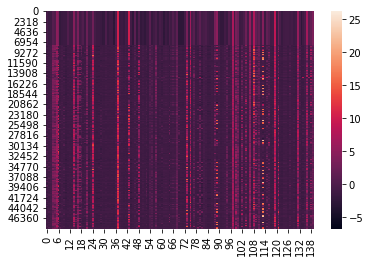

In [19]:
sns.heatmap(preds)

In [17]:
def submit(test_pred,multi_path):
    submission = pd.read_csv(multi_path,index_col = 0)
    submission = submission["target"]
    print("data loaded")
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
    assert not submission.isna().any()
    # submission = submission.round(6) # reduce the size of the csv
    print("start -> submission.zip")
    submission.to_csv('submission.zip')
    print("submission.zip saved!")

In [20]:
%%time
submit(preds,multi_path = r"D:\python_project\MSCI\model_ensemble\submission_best.zip")

data loaded
start -> submission.zip
submission.zip saved!
CPU times: total: 1min 19s
Wall time: 3min 2s
